# 1. **Data Collection & Preprocessing:**

In [113]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import random
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

In [1]:
file_path = "sample_data/music_corpus.txt"
with open(file_path, 'r') as file:
    text = file.read()

In [3]:
np.unique(np.array(text.split(" "))).__len__()

883

* There are 883 unique words in the corpus

In [4]:
def cleaning(text):
    text = text.lower()
    words = word_tokenize(text)
    words_punct_rem = [word for word in words if word.isalpha()]
    stop_words_en = set(stopwords.words('english'))
    words_stopwords_rem = [word for word in words_punct_rem if word not in stop_words_en]
    return words_stopwords_rem

In [5]:
cleaned_words = cleaning(text=text)

In [6]:
len(cleaned_words)

8214

In [7]:
words, counts = np.unique(np.array(cleaned_words), return_counts=True)

In [8]:
df = pd.DataFrame()
df['words'] = words
df['counts'] = counts

In [10]:
df.sort_values('counts', ascending=False).head(20)

,words,counts
453,time,336
478,values,258
343,pulse,222
258,meter,168
130,durational,150
81,compound,150
398,simple,138
462,two,126
273,music,120
250,may,102


* The top 20 most frequent words are displayed in the dataframe above

# 2. **Word2Vec Model Training:**

In [222]:
class train_custom_word2vec():
    def __init__(self, approach, embed_dim, context_window, min_freq=1, subsample_threshold=0):
        self.word_tokenize = word_tokenize
        self.stopwords = stopwords
        self.approach = approach
        self.embed_dim = embed_dim
        self.context_window = context_window
        self.min_freq = min_freq
        self.subsample_threshold = subsample_threshold

        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            self.device = torch.device("mps")
        else:
            self.device = torch.device("cpu")
        pass

    def cleaning_raw_text(self, text):

        text = text.lower()
        words = self.word_tokenize(text)
        words_punct_rem = [word for word in words if word.isalpha()]
        stop_words_en = set(self.stopwords.words('english'))
        words_stopwords_rem = [word for word in words_punct_rem if word not in stop_words_en]
        
        return words_stopwords_rem
    
    def subsample(self, corpus, threshold):
        word_counts = Counter(corpus)
        total_count = len(corpus)
        word_freq = {word: count / total_count for word, count in word_counts.items()}
        discard_probs = {word: 1 - (threshold / freq)**0.5 for word, freq in word_freq.items() if freq > threshold}
        subsampled = [word for word in corpus if word not in discard_probs or random.random() > discard_probs[word]]
        return subsampled
    
    def create_vocab_mapping(self, cleaned_words):
        self.vocab_mapping = {}
        unique_words = np.unique(np.array(cleaned_words)).tolist()
        for i, word in enumerate(unique_words):
            if word not in self.vocab_mapping:
                self.vocab_mapping[word] = i
        return self.vocab_mapping

    def create_pairs(self, cleaned_words):
        if self.min_freq > 1:
            cleaned_words = [word for word in cleaned_words if cleaned_words.count(word) >= self.min_freq]
        if self.subsample_threshold > 0:
            cleaned_words = self.subsample(corpus=cleaned_words, threshold=self.subsample_threshold)
        self.create_vocab_mapping(cleaned_words=cleaned_words)
        if self.approach == "cbow":
            cbow_pairs = []
            for i, target_word in enumerate(cleaned_words):
                context_words = cleaned_words[max(0, i-self.context_window):i] + cleaned_words[i+1:min(len(cleaned_words), i+self.context_window+1)]
                cbow_pairs.append((context_words, target_word))
            return cbow_pairs

        elif self.approach == "skip-gram":
            skipgram_pairs = []
            for i, target_word in enumerate(cleaned_words):
                context_words = cleaned_words[max(0, i-self.context_window):i] + cleaned_words[i+1:min(len(cleaned_words), i+self.context_window+1)]
                tmp_pairs = [(target_word, context_word) for context_word in context_words]
                skipgram_pairs.extend(tmp_pairs)
            return skipgram_pairs
    
    def one_hot_encoding(self, word, vocab_size):
        # one_hot_vector = np.zeros(vocab_size)
        one_hot_vector = torch.zeros(vocab_size)
        one_hot_vector[self.vocab_mapping[word]] = 1
        return one_hot_vector
    
    def create_training_data(self, text):
        cleaned_words = self.cleaning_raw_text(text=text)
        # self.create_vocab_mapping(cleaned_words=cleaned_words)
        pairs = self.create_pairs(cleaned_words=cleaned_words)
        if self.approach=="cbow":
            training_data = []
            for context_words, target_word in pairs:
                context_words_one_hot = [self.one_hot_encoding(word=word, vocab_size=len(self.vocab_mapping)) for word in context_words]
                target_word_one_hot = self.one_hot_encoding(word=target_word, vocab_size=len(self.vocab_mapping))
                training_data.append((torch.sum(torch.stack(context_words_one_hot), dim=0), target_word_one_hot))
            return training_data

        elif self.approach=="skip-gram": 
            training_data = []
            for target_word, context_word in pairs:
                target_word_one_hot = self.one_hot_encoding(word=target_word, vocab_size=len(self.vocab_mapping))
                context_word_one_hot = self.one_hot_encoding(word=context_word, vocab_size=len(self.vocab_mapping))
                training_data.append((target_word_one_hot, context_word_one_hot))
            return training_data
    
    def initialize_model(self):
        self.linear1 = nn.Linear(len(self.vocab_mapping), self.embed_dim, bias=False)
        self.linear2 = nn.Linear(self.embed_dim, len(self.vocab_mapping), bias=False)
    
    def create_model(self):
        self.initialize_model()
        self.model = nn.Sequential(self.linear1, self.linear2)
        self.model.to(self.device)
        
    def train_w2v(self, text, num_epochs, learning_rate, batch_size, loss="cross_entropy", verbose=False):
        training_data = self.create_training_data(text=text)
        train_data, val_data = train_test_split(training_data, test_size=0.1, random_state=42)
        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

        self.create_model()
        if loss == "cross_entropy":
            loss = nn.CrossEntropyLoss()
        elif loss == "heirarchical_softmax":
            loss = nn.BCEWithLogitsLoss()
        elif loss == "negative_sampling":
            loss = nn.NegativeSamplingLoss()
        optimizer = optim.Adagrad(self.model.parameters(), lr=learning_rate)

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            self.model.train()
            total_train_loss = 0
            total_val_loss = 0
            num_train_batches = 0
            num_val_batches = 0

            for inputs, labels in train_dataloader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                optimizer.zero_grad()
                y_train_logits = self.model(inputs)
                train_loss = loss(y_train_logits, labels)
                train_loss.backward()
                optimizer.step()
                total_train_loss += train_loss.item()
                num_train_batches += 1
            
            average_train_loss = total_train_loss/num_train_batches
            train_losses.append(average_train_loss)
        
            self.model.eval()
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    y_val_logits = self.model(inputs)
                    val_loss = loss(y_val_logits, labels)
                    total_val_loss += val_loss.item()
                    num_val_batches += 1
            
            average_val_loss = total_val_loss/num_val_batches
            val_losses.append(average_val_loss)
            
            if verbose:
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}")
        
        return self.model, train_losses, val_losses, self.vocab_mapping


In [164]:
w2v_model = train_custom_word2vec(approach="skip-gram", embed_dim=100, context_window=5, min_freq=5, subsample_threshold=1e-5)

In [165]:
w2v_model.train_w2v(text=text, num_epochs=10, learning_rate=0.01, batch_size=64, verbose=True)

Epoch 1/10, Train Loss: 5.7686, Val Loss: 5.7612
Epoch 2/10, Train Loss: 5.7134, Val Loss: 5.7372
Epoch 3/10, Train Loss: 5.6546, Val Loss: 5.6980
Epoch 4/10, Train Loss: 5.5806, Val Loss: 5.6455
Epoch 5/10, Train Loss: 5.4922, Val Loss: 5.5815
Epoch 6/10, Train Loss: 5.3919, Val Loss: 5.5093
Epoch 7/10, Train Loss: 5.2837, Val Loss: 5.4311
Epoch 8/10, Train Loss: 5.1711, Val Loss: 5.3521
Epoch 9/10, Train Loss: 5.0571, Val Loss: 5.2756
Epoch 10/10, Train Loss: 4.9444, Val Loss: 5.1972


(Sequential(
   (0): Linear(in_features=321, out_features=100, bias=False)
   (1): Linear(in_features=100, out_features=321, bias=False)
 ),
 [5.768556332923997,
  5.71335347941224,
  5.654582715370286,
  5.580591228646292,
  5.49218826562586,
  5.39192564386717,
  5.283744308310495,
  5.171053423008448,
  5.0570823911210185,
  4.944423695685158],
 [5.761211335659027,
  5.737155914306641,
  5.697953402996063,
  5.645472407341003,
  5.581531345844269,
  5.5093231201171875,
  5.431052267551422,
  5.352102637290955,
  5.275568425655365,
  5.197194218635559])

* Experimenting with different hyperparameters

In [174]:
experiment_configs = [
    # Varying vector dimensions
    {
        'vector_dim': 50,
        'window_size': 5,
        'approach': 'skip-gram'
    },
    {
        'vector_dim': 100,
        'window_size': 5,
        'approach': 'skip-gram'
    },
    {
        'vector_dim': 300,
        'window_size': 5,
        'approach': 'skip-gram'
    },
    {
        'vector_dim': 50,
        'window_size': 5,
        'approach': 'cbow'
    },
    {
        'vector_dim': 100,
        'window_size': 5,
        'approach': 'cbow'
    },
    {
        'vector_dim': 300,
        'window_size': 5,
        'approach': 'cbow'
    },
    
    # Varying window sizes
    {
        'vector_dim': 100,
        'window_size': 3,
        'approach': 'skip-gram'
    },
    {
        'vector_dim': 100,
        'window_size': 5,
        'approach': 'skip-gram'
    },
    {
        'vector_dim': 100,
        'window_size': 10,
        'approach': 'skip-gram'
    },
    {
        'vector_dim': 100,
        'window_size': 3,
        'approach': 'cbow'
    },
    {
        'vector_dim': 100,
        'window_size': 5,
        'approach': 'cbow'
    },
    {
        'vector_dim': 100,
        'window_size': 10,
        'approach': 'cbow'
    },
    
    # Varying minimum frequency thresholds
    {
        'vector_dim': 100,
        'window_size': 5,
        'min_freq': 2,
        'approach': 'skip-gram'
    },
    {
        'vector_dim': 100,
        'window_size': 5,
        'min_freq': 10,
        'approach': 'skip-gram'
    },
    
    # Sub-sampling thresholds
    {
        'vector_dim': 100,
        'window_size': 5,
        'subsampling_threshold': 1e-4,
        'approach': 'skip-gram'
    },
    {
        'vector_dim': 100,
        'window_size': 5,
        'subsampling_threshold': 1e-6,
        'approach': 'skip-gram'
    }
]


In [175]:
results = {}
for i, config in enumerate(experiment_configs):
    print(f"\nRunning experiment {i+1}/{len(experiment_configs)}")
    print("Configuration:", config)
    
    w2v_model = train_custom_word2vec(approach=config.get('approach', 'skip-gram'), 
                                      embed_dim=config['vector_dim'],
                                      context_window=config['window_size'],
                                      min_freq=config.get('min_freq', 5),
                                      subsample_threshold=config.get('subsampling_threshold', 1e-5)
                                      )
    
    model, train_losses, val_losses, vocab_mapping = w2v_model.train_w2v(text=text, num_epochs=100, learning_rate=0.01, batch_size=64, verbose=True)
    
    results[f"experiment_{i+1}"] = {'config': config, 'final_train_loss': train_losses[-1], 'final_val_loss': val_losses[-1]}


Running experiment 1/16
Configuration: {'vector_dim': 50, 'window_size': 5, 'approach': 'skip-gram'}
Epoch 1/100, Train Loss: 5.6988, Val Loss: 5.6971
Epoch 2/100, Train Loss: 5.6670, Val Loss: 5.6869
Epoch 3/100, Train Loss: 5.6369, Val Loss: 5.6703
Epoch 4/100, Train Loss: 5.6005, Val Loss: 5.6480
Epoch 5/100, Train Loss: 5.5575, Val Loss: 5.6197
Epoch 6/100, Train Loss: 5.5085, Val Loss: 5.5872
Epoch 7/100, Train Loss: 5.4545, Val Loss: 5.5497
Epoch 8/100, Train Loss: 5.3965, Val Loss: 5.5106
Epoch 9/100, Train Loss: 5.3355, Val Loss: 5.4687
Epoch 10/100, Train Loss: 5.2735, Val Loss: 5.4282
Epoch 11/100, Train Loss: 5.2105, Val Loss: 5.3855
Epoch 12/100, Train Loss: 5.1472, Val Loss: 5.3438
Epoch 13/100, Train Loss: 5.0852, Val Loss: 5.2995
Epoch 14/100, Train Loss: 5.0244, Val Loss: 5.2605
Epoch 15/100, Train Loss: 4.9645, Val Loss: 5.2241
Epoch 16/100, Train Loss: 4.9071, Val Loss: 5.1856
Epoch 17/100, Train Loss: 4.8508, Val Loss: 5.1533
Epoch 18/100, Train Loss: 4.7974, Val Lo

In [ ]:
w2v_model = train_custom_word2vec(approach='cbow', 
                                    embed_dim=100,
                                    context_window=5,
                                    min_freq=1)

model, train_losses, val_losses, vocab_mapping = w2v_model.train_w2v(text=text, num_epochs=100, learning_rate=0.01, batch_size=64, loss="heirarchical_softmax", verbose=True)

results[f"experiment_17"] = {'config': config, 'final_train_loss': train_losses[-1], 'final_val_loss': val_losses[-1]}

Epoch 1/100, Train Loss: 0.0578, Val Loss: 0.0141
Epoch 2/100, Train Loss: 0.0136, Val Loss: 0.0135
Epoch 3/100, Train Loss: 0.0133, Val Loss: 0.0134
Epoch 4/100, Train Loss: 0.0132, Val Loss: 0.0133
Epoch 5/100, Train Loss: 0.0132, Val Loss: 0.0133
Epoch 6/100, Train Loss: 0.0131, Val Loss: 0.0132
Epoch 7/100, Train Loss: 0.0130, Val Loss: 0.0132
Epoch 8/100, Train Loss: 0.0129, Val Loss: 0.0131
Epoch 9/100, Train Loss: 0.0129, Val Loss: 0.0130
Epoch 10/100, Train Loss: 0.0128, Val Loss: 0.0130
Epoch 11/100, Train Loss: 0.0127, Val Loss: 0.0129
Epoch 12/100, Train Loss: 0.0125, Val Loss: 0.0128
Epoch 13/100, Train Loss: 0.0124, Val Loss: 0.0126
Epoch 14/100, Train Loss: 0.0123, Val Loss: 0.0125
Epoch 15/100, Train Loss: 0.0122, Val Loss: 0.0124
Epoch 16/100, Train Loss: 0.0121, Val Loss: 0.0123
Epoch 17/100, Train Loss: 0.0119, Val Loss: 0.0122
Epoch 18/100, Train Loss: 0.0118, Val Loss: 0.0121
Epoch 19/100, Train Loss: 0.0117, Val Loss: 0.0120
Epoch 20/100, Train Loss: 0.0116, Val Lo

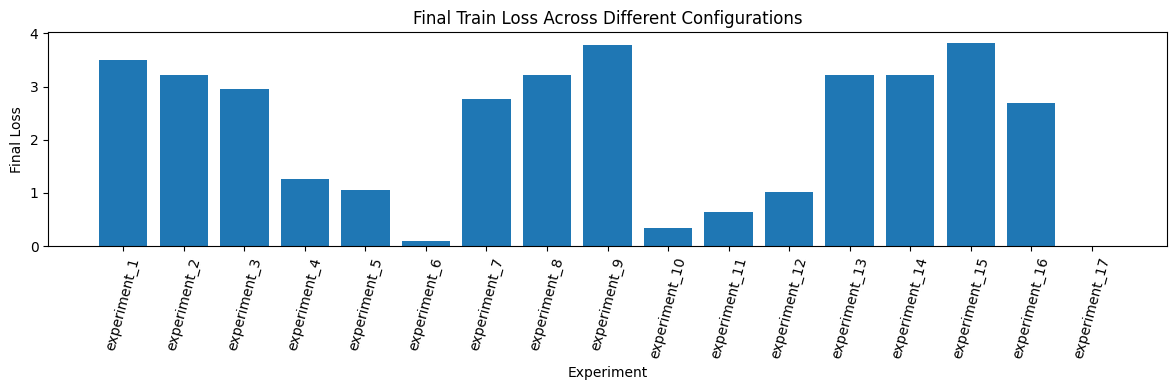

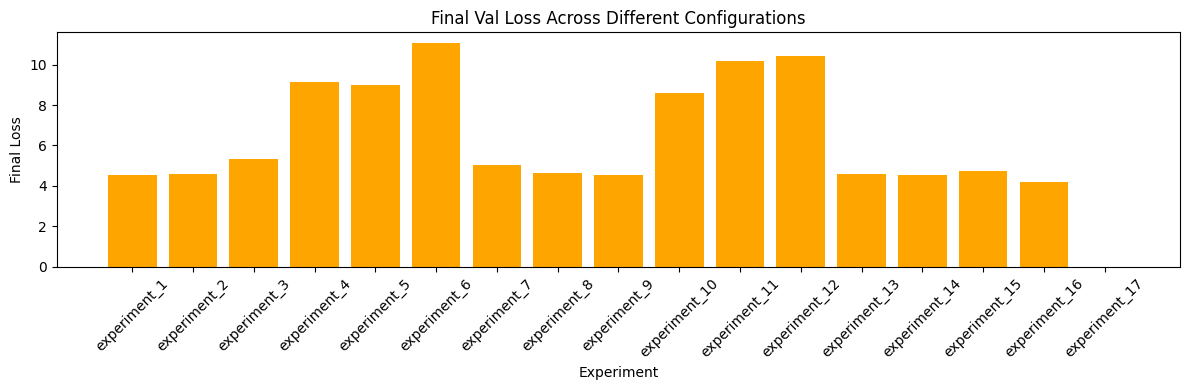


experiment_1:
Configuration: {'vector_dim': 50, 'window_size': 5, 'approach': 'skip-gram'}
Final Train Loss: 3.5041832509248154
Final Val Loss: 4.548346817493439

experiment_2:
Configuration: {'vector_dim': 100, 'window_size': 5, 'approach': 'skip-gram'}
Final Train Loss: 3.2145375099734985
Final Val Loss: 4.580437242984772

experiment_3:
Configuration: {'vector_dim': 300, 'window_size': 5, 'approach': 'skip-gram'}
Final Train Loss: 2.9570519818979153
Final Val Loss: 5.323905885219574

experiment_4:
Configuration: {'vector_dim': 50, 'window_size': 5, 'approach': 'cbow'}
Final Train Loss: 1.2606851756572723
Final Val Loss: 9.15792465209961

experiment_5:
Configuration: {'vector_dim': 100, 'window_size': 5, 'approach': 'cbow'}
Final Train Loss: 1.057871662080288
Final Val Loss: 8.968314170837402

experiment_6:
Configuration: {'vector_dim': 300, 'window_size': 5, 'approach': 'cbow'}
Final Train Loss: 0.0953088743346078
Final Val Loss: 11.043919563293457

experiment_7:
Configuration: {'ve

In [193]:

plt.figure(figsize=(12, 4))
exp_names = list(results.keys())
train_losses = [r['final_train_loss'] for r in results.values()]
plt.bar(exp_names, train_losses)
plt.xticks(rotation=75)
plt.title('Final Train Loss Across Different Configurations')
plt.xlabel('Experiment')
plt.ylabel('Final Loss')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
exp_names = list(results.keys())
val_losses = [r['final_val_loss'] for r in results.values()]
plt.bar(exp_names, val_losses, color='orange')
plt.xticks(rotation=45)
plt.title('Final Val Loss Across Different Configurations')
plt.xlabel('Experiment')
plt.ylabel('Final Loss')
plt.tight_layout()
plt.show()


for exp_name, result in results.items():
    print(f"\n{exp_name}:")
    print("Configuration:", result['config'])
    print("Final Train Loss:", result['final_train_loss'])
    print("Final Val Loss:", result['final_val_loss'])

The following model configuration achieved the best performance:

- **Vector Dimension**: `100`

- **Window Size**: `5`

- **Minimum Frequency**: `1`

- **Subsampling Threshold**: `0`

- **Approach**: `CBOW`

- **Loss Function**: `Hierarchical Softmax`

In [223]:
# cbow_model = model
w2v_model_cbow = train_custom_word2vec(approach='cbow', 
                                    embed_dim=100,
                                    context_window=5,
                                    min_freq=1)

cbow_model, train_losses, val_losses, cbow_vocab_mapping = w2v_model_cbow.train_w2v(text=text, num_epochs=100, learning_rate=0.01,
                                                               batch_size=64, loss="heirarchical_softmax", verbose=True)

Epoch 1/100, Train Loss: 0.0599, Val Loss: 0.0141
Epoch 2/100, Train Loss: 0.0136, Val Loss: 0.0135
Epoch 3/100, Train Loss: 0.0134, Val Loss: 0.0134
Epoch 4/100, Train Loss: 0.0132, Val Loss: 0.0134
Epoch 5/100, Train Loss: 0.0132, Val Loss: 0.0133
Epoch 6/100, Train Loss: 0.0131, Val Loss: 0.0132
Epoch 7/100, Train Loss: 0.0130, Val Loss: 0.0132
Epoch 8/100, Train Loss: 0.0129, Val Loss: 0.0131
Epoch 9/100, Train Loss: 0.0129, Val Loss: 0.0130
Epoch 10/100, Train Loss: 0.0127, Val Loss: 0.0129
Epoch 11/100, Train Loss: 0.0126, Val Loss: 0.0128
Epoch 12/100, Train Loss: 0.0125, Val Loss: 0.0127
Epoch 13/100, Train Loss: 0.0124, Val Loss: 0.0126
Epoch 14/100, Train Loss: 0.0123, Val Loss: 0.0125
Epoch 15/100, Train Loss: 0.0122, Val Loss: 0.0124
Epoch 16/100, Train Loss: 0.0121, Val Loss: 0.0123
Epoch 17/100, Train Loss: 0.0119, Val Loss: 0.0122
Epoch 18/100, Train Loss: 0.0118, Val Loss: 0.0121
Epoch 19/100, Train Loss: 0.0117, Val Loss: 0.0120
Epoch 20/100, Train Loss: 0.0116, Val Lo

In [224]:
cbow_vocab_mapping

{'able': 0,
 'academics': 1,
 'accents': 2,
 'accentuated': 3,
 'accentuation': 4,
 'accepted': 5,
 'according': 6,
 'accordingly': 7,
 'action': 8,
 'adapted': 9,
 'added': 10,
 'addition': 11,
 'additional': 12,
 'additionally': 13,
 'address': 14,
 'adjacent': 15,
 'alla': 16,
 'allegro': 17,
 'allowed': 18,
 'along': 19,
 'also': 20,
 'analyze': 21,
 'analyzing': 22,
 'andante': 23,
 'andantino': 24,
 'another': 25,
 'answering': 26,
 'anyone': 27,
 'anywhere': 28,
 'appended': 29,
 'appendix': 30,
 'arbitrary': 31,
 'arhythmic': 32,
 'around': 33,
 'arsis': 34,
 'aspects': 35,
 'assign': 36,
 'assigned': 37,
 'assist': 38,
 'attempt': 39,
 'attribute': 40,
 'b': 41,
 'background': 42,
 'basic': 43,
 'beams': 44,
 'beat': 45,
 'beats': 46,
 'becomes': 47,
 'beethoven': 48,
 'beginning': 49,
 'best': 50,
 'blackened': 51,
 'bottom': 52,
 'boundary': 53,
 'bpm': 54,
 'breve': 55,
 'brilliance': 56,
 'brio': 57,
 'called': 58,
 'came': 59,
 'capacity': 60,
 'carry': 61,
 'cease': 62,


In [225]:
w2v_model_skipgram = train_custom_word2vec(approach='skip-gram', 
                                    embed_dim=100,
                                    context_window=5,
                                    min_freq=1,
                                    subsample_threshold=1e-06)

skipgram_model, train_losses, val_losses, skipgram_vocab_mapping = w2v_model_skipgram.train_w2v(text=text, num_epochs=100, learning_rate=0.01, batch_size=64, verbose=True)

Epoch 1/100, Train Loss: 4.9193, Val Loss: 4.9165
Epoch 2/100, Train Loss: 4.8604, Val Loss: 4.9023
Epoch 3/100, Train Loss: 4.8096, Val Loss: 4.8777
Epoch 4/100, Train Loss: 4.7520, Val Loss: 4.8455
Epoch 5/100, Train Loss: 4.6869, Val Loss: 4.8021
Epoch 6/100, Train Loss: 4.6147, Val Loss: 4.7643
Epoch 7/100, Train Loss: 4.5364, Val Loss: 4.7080
Epoch 8/100, Train Loss: 4.4535, Val Loss: 4.6485
Epoch 9/100, Train Loss: 4.3673, Val Loss: 4.6019
Epoch 10/100, Train Loss: 4.2797, Val Loss: 4.5360
Epoch 11/100, Train Loss: 4.1914, Val Loss: 4.4713
Epoch 12/100, Train Loss: 4.1042, Val Loss: 4.3936
Epoch 13/100, Train Loss: 4.0193, Val Loss: 4.3635
Epoch 14/100, Train Loss: 3.9366, Val Loss: 4.3157
Epoch 15/100, Train Loss: 3.8581, Val Loss: 4.2586
Epoch 16/100, Train Loss: 3.7829, Val Loss: 4.2105
Epoch 17/100, Train Loss: 3.7122, Val Loss: 4.1871
Epoch 18/100, Train Loss: 3.6458, Val Loss: 4.1322
Epoch 19/100, Train Loss: 3.5839, Val Loss: 4.1103
Epoch 20/100, Train Loss: 3.5262, Val Lo

In [226]:
skipgram_vocab_mapping

{'adapted': 0,
 'additionally': 1,
 'address': 2,
 'analyzing': 3,
 'another': 4,
 'anyone': 5,
 'anywhere': 6,
 'arsis': 7,
 'beat': 8,
 'beats': 9,
 'blackened': 10,
 'called': 11,
 'came': 12,
 'carry': 13,
 'century': 14,
 'chapter': 15,
 'characteristics': 16,
 'come': 17,
 'commonly': 18,
 'compels': 19,
 'compound': 20,
 'consist': 21,
 'context': 22,
 'convenience': 23,
 'countries': 24,
 'criteria': 25,
 'current': 26,
 'definitions': 27,
 'delineate': 28,
 'depending': 29,
 'described': 30,
 'determinant': 31,
 'determined': 32,
 'discuss': 33,
 'divide': 34,
 'division': 35,
 'downbeat': 36,
 'duple': 37,
 'durational': 38,
 'early': 39,
 'either': 40,
 'elements': 41,
 'employed': 42,
 'equivalent': 43,
 'established': 44,
 'example': 45,
 'examples': 46,
 'fire': 47,
 'first': 48,
 'following': 49,
 'forth': 50,
 'found': 51,
 'foundation': 52,
 'fundamental': 53,
 'given': 54,
 'groupings': 55,
 'holdovers': 56,
 'incorporating': 57,
 'indicates': 58,
 'individual': 59,
 

In [254]:
list(cbow_model.parameters())[0].detach().T.shape

torch.Size([495, 100])

In [255]:
cbow_vectors = {word: vector for word, vector in zip(cbow_vocab_mapping.keys(),
                                                      list(cbow_model.parameters())[0].detach().T)}
skipgram_vectors = {word: vector for word, vector in zip(skipgram_vocab_mapping.keys(), 
                                                         list(skipgram_model.parameters())[0].detach().T)}

In [263]:
for k,v in cbow_vectors.items():
    cbow_vectors[k] = v.to("cpu")
for k,v in skipgram_vectors.items():
    skipgram_vectors[k] = v.to("cpu")

# 3. **Evaluation of Embeddings:**

In [228]:
from sklearn.metrics.pairwise import cosine_similarity

In [269]:
df.sort_values('counts', ascending=False).head(20)

,words,counts
453,time,336
478,values,258
343,pulse,222
258,meter,168
130,durational,150
81,compound,150
398,simple,138
462,two,126
273,music,120
250,may,102


In [276]:
def find_similar_words(target_word, word2idx_mapping, word_vectors, top_n=10):
    # if target_word not in word2idx_mapping:
    #     return f"Word '{target_word}' not in vocabulary"
        
    target_vector = word_vectors[target_word]
    similarities = cosine_similarity([target_vector], list(word_vectors.values()))[0]
    most_similar = similarities.argsort()[:-top_n-1:-1]
    results = []
    for idx in most_similar:
        word = word2idx_mapping[idx]
        if word != target_word:
            results.append((word, similarities[idx]))
    return results

In [279]:
cbow_vocab_mapping_reverse = {v: k for k, v in cbow_vocab_mapping.items()}
skipgram_vocab_mapping_reverse = {v: k for k, v in skipgram_vocab_mapping.items()}

In [278]:
find_similar_words(target_word="music", word2idx_mapping=cbow_vocab_mapping_reverse, word_vectors=cbow_vectors)

[('make', np.float32(0.53336906)),
 ('western', np.float32(0.5288425)),
 ('uniting', np.float32(0.5286288)),
 ('initially', np.float32(0.52349913)),
 ('common', np.float32(0.52272236)),
 ('space', np.float32(0.51002353)),
 ('kinesthetically', np.float32(0.5080665)),
 ('organized', np.float32(0.5038962)),
 ('progress', np.float32(0.49810132))]

In [306]:
find_similar_words(target_word="time", word2idx_mapping=skipgram_vocab_mapping_reverse, word_vectors=skipgram_vectors)

[('divide', np.float32(0.7458001)),
 ('using', np.float32(0.7361933)),
 ('either', np.float32(0.6778027)),
 ('polyphony', np.float32(0.6668322)),
 ('representing', np.float32(0.6034572)),
 ('orthographically', np.float32(0.58960044)),
 ('understand', np.float32(0.55616045)),
 ('employed', np.float32(0.5415336)),
 ('meters', np.float32(0.5227525))]

In [286]:
def analogy_test(word1, word2, word3, word_vectors, idx2word, top_n=10):
    v1 = word_vectors[word1]
    v2 = word_vectors[word2]
    v3 = word_vectors[word3]
    target_vector = v2 - v1 + v3
    similarities = cosine_similarity([target_vector], list(word_vectors.values()))[0]
    most_similar = similarities.argsort()[-top_n:][::-1]
    
    results = []
    for idx in most_similar:
        word = idx2word[idx]
        if word not in [word1, word2, word3]:
            results.append((word, similarities[idx]))
            
    return results

In [287]:
analogy_test(word1="time", word2="pulse", word3="music", word_vectors=cbow_vectors, idx2word=cbow_vocab_mapping_reverse)

[('assigned', np.float32(0.43774322)),
 ('another', np.float32(0.42793018)),
 ('chain', np.float32(0.42659295)),
 ('academics', np.float32(0.41175166)),
 ('notation', np.float32(0.40324005)),
 ('uniting', np.float32(0.4011035)),
 ('notable', np.float32(0.39938086)),
 ('flags', np.float32(0.3961572))]

# 4. **Visualization**

In [294]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random

CBOW Embeddings Visualization (random sample):


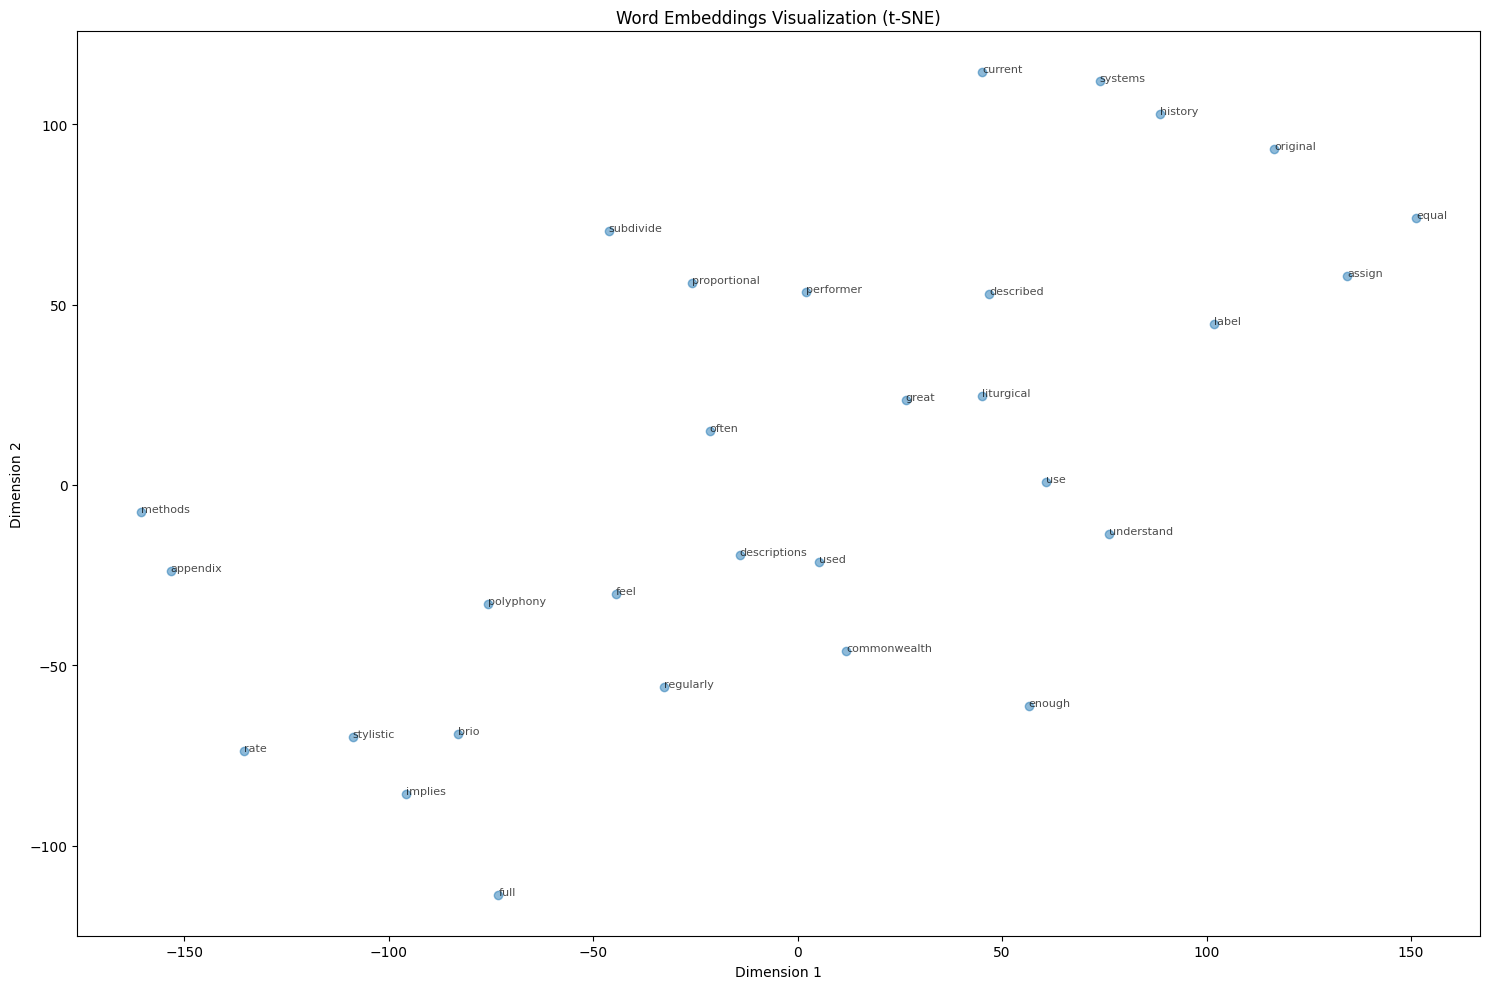

In [ ]:

def plot_word_embeddings(word_vectors, num_words=50, perplexity=5):
    
    words = list(word_vectors.keys())
    vectors = []
    
    if num_words < len(words):
        selected_words = random.sample(words, num_words)
    else:
        selected_words = words
        
    selected_vectors = []
    for word in selected_words:
        vector = word_vectors[word].numpy()
        selected_vectors.append(vector)
    selected_vectors = np.array(selected_vectors)
    
    tsne = TSNE(n_components=2, perplexity=min(perplexity, len(selected_words)-1), 
                random_state=42, init='pca')
    reduced_vectors = tsne.fit_transform(selected_vectors)
    
    plt.figure(figsize=(15, 10))
    
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.5)
    
    for i, word in enumerate(selected_words):
        plt.annotate(word, 
                    (reduced_vectors[i, 0], reduced_vectors[i, 1]),
                    fontsize=8,
                    alpha=0.7)
    
    plt.title("Word Embeddings Visualization (t-SNE)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.tight_layout()
    plt.show()

print("CBOW Embeddings Visualization (random sample):")
plot_word_embeddings(cbow_vectors, num_words=30)



Music-related terms visualization:


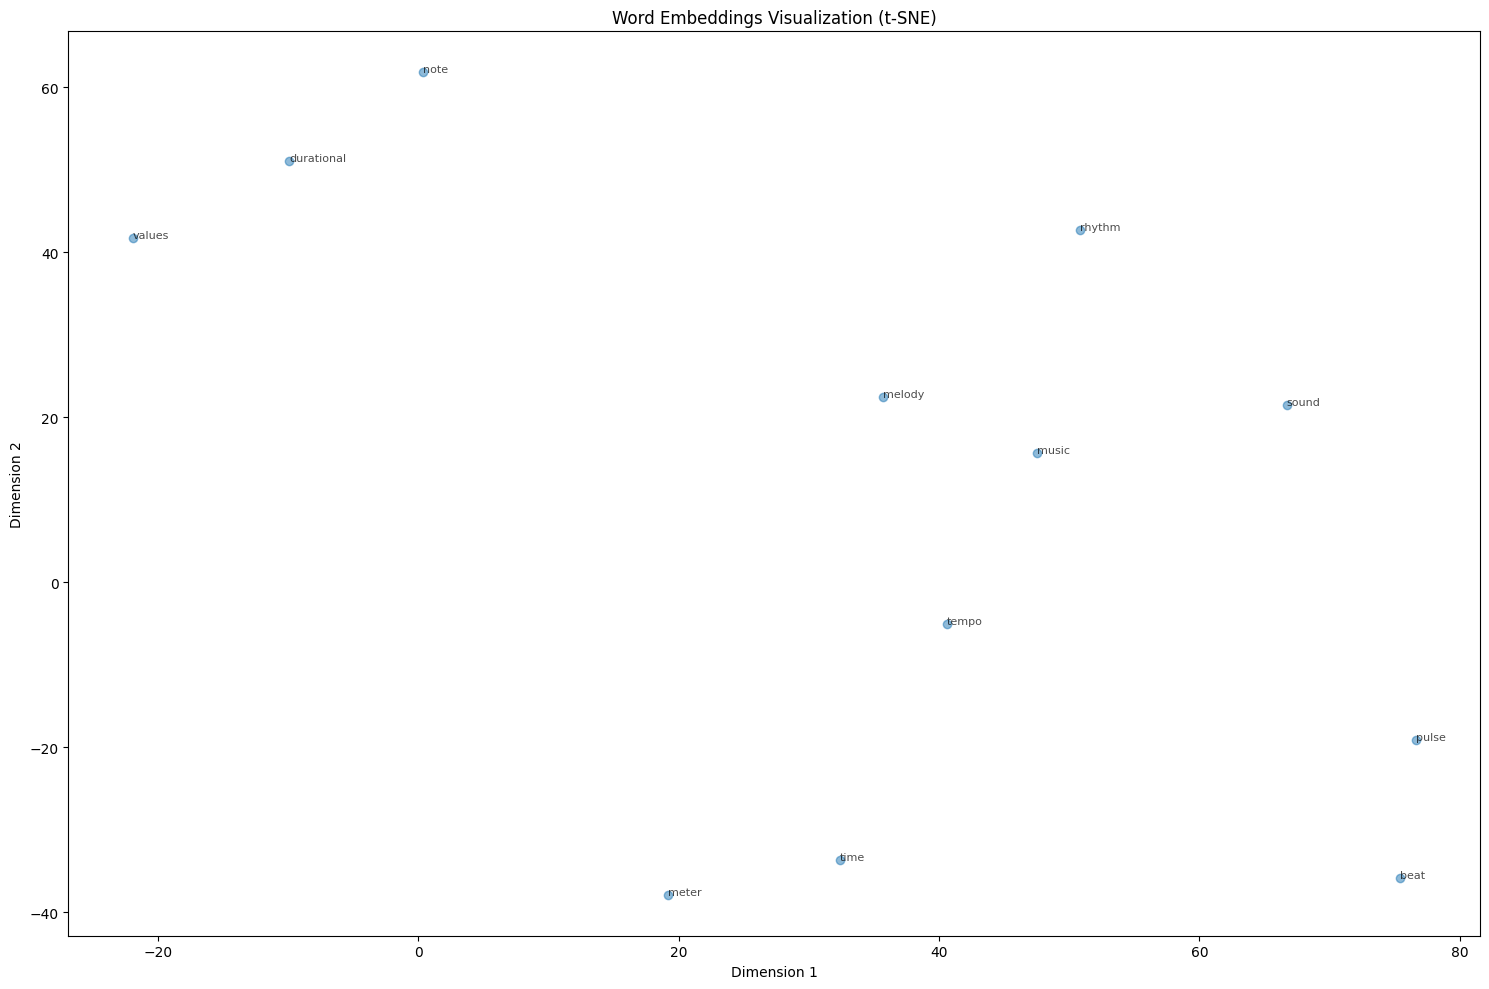

In [297]:

music_terms = {word: vector for word, vector in cbow_vectors.items() 
              if word in ['music', 'tempo', 'rhythm', 'meter', 'pulse', 'beat', 'time', 
                         'note', 'sound', 'melody', 'durational', 'values']}
print("\nMusic-related terms visualization:")
plot_word_embeddings(music_terms, num_words=len(music_terms), perplexity=3)


Most frequent 100 words visualization:


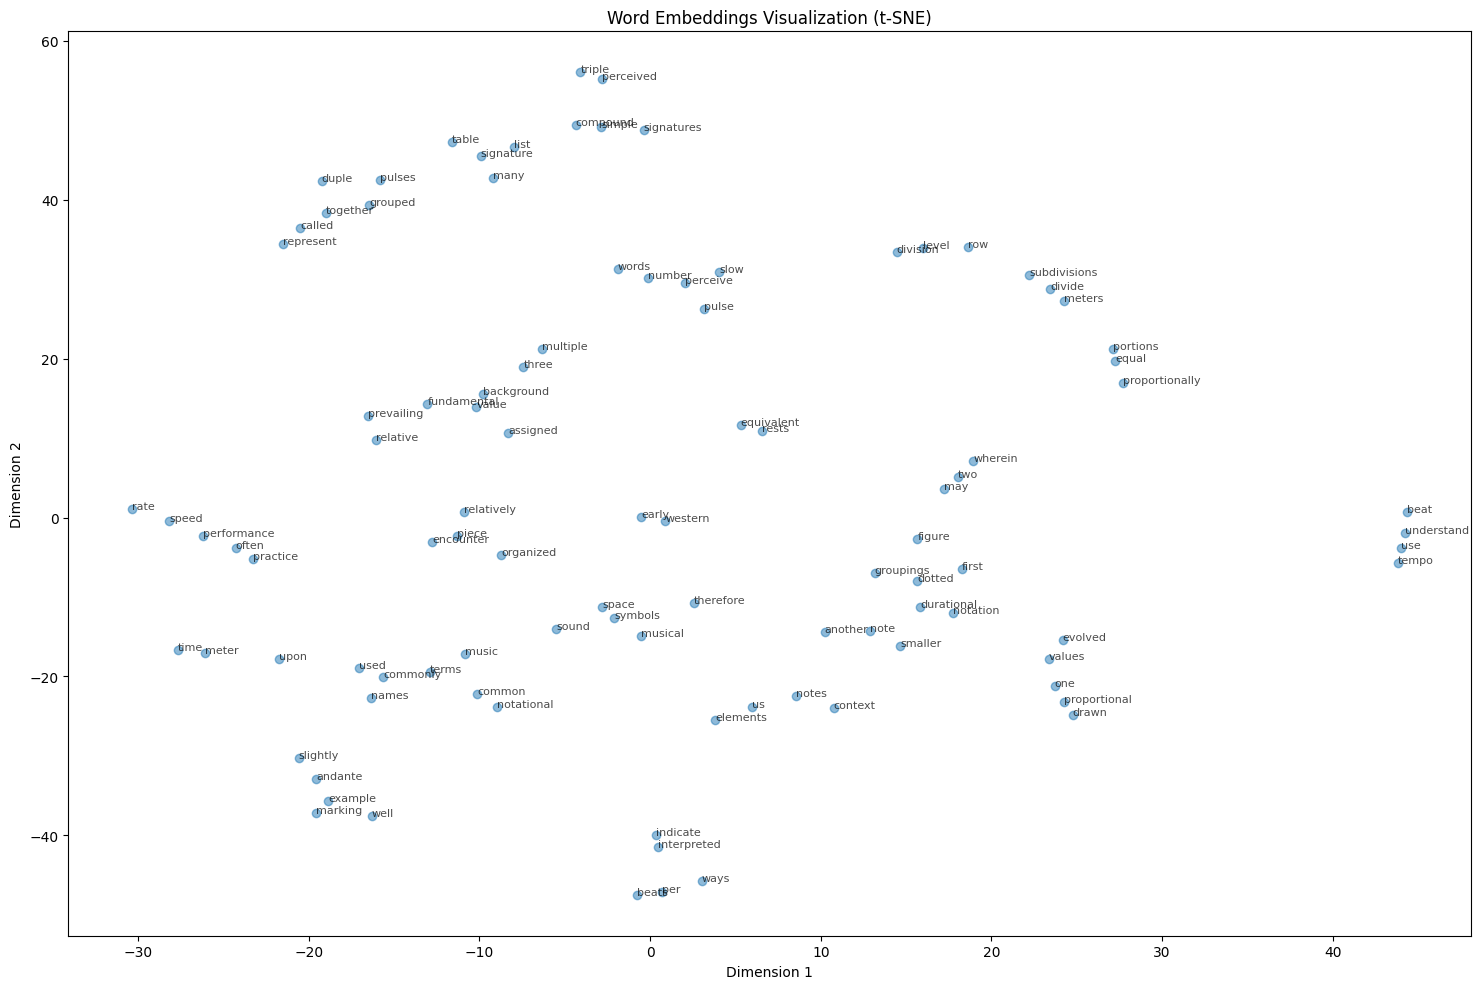

In [305]:
# Compare most frequent words
# top_words = ['time', 'values', 'pulse', 'meter', 'durational', 'compound', 
#              'simple', 'two', 'music', 'may']
top_words = list(df.sort_values('counts', ascending=False)['words'].values[:100])
frequent_words = {word: vector for word, vector in cbow_vectors.items() 
                 if word in top_words}
print("\nMost frequent 100 words visualization:")
plot_word_embeddings(frequent_words, num_words=len(frequent_words), perplexity=3)